<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В распоряжении имеются данные о поведении клиентов и расторжении договоров с банком.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

**Подключаем все необходимые библеотеки**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from math import ceil
from sklearn.preprocessing import StandardScaler

**Загарузим данные и проверим их**

In [5]:
# загрузка данных
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv(r"C:\Users\kil_a\OneDrive\Рабочий стол\Проекты ЯП\Банк и уход клиентов\Уход клиентов.csv")
# выведем первые 5 строк, чтобы убедиться, что данные загружены
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Выведем информацию о данных и изучим пропуски**

In [6]:
# метод info к данным 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Для краткого обзора данных построим гистограммы

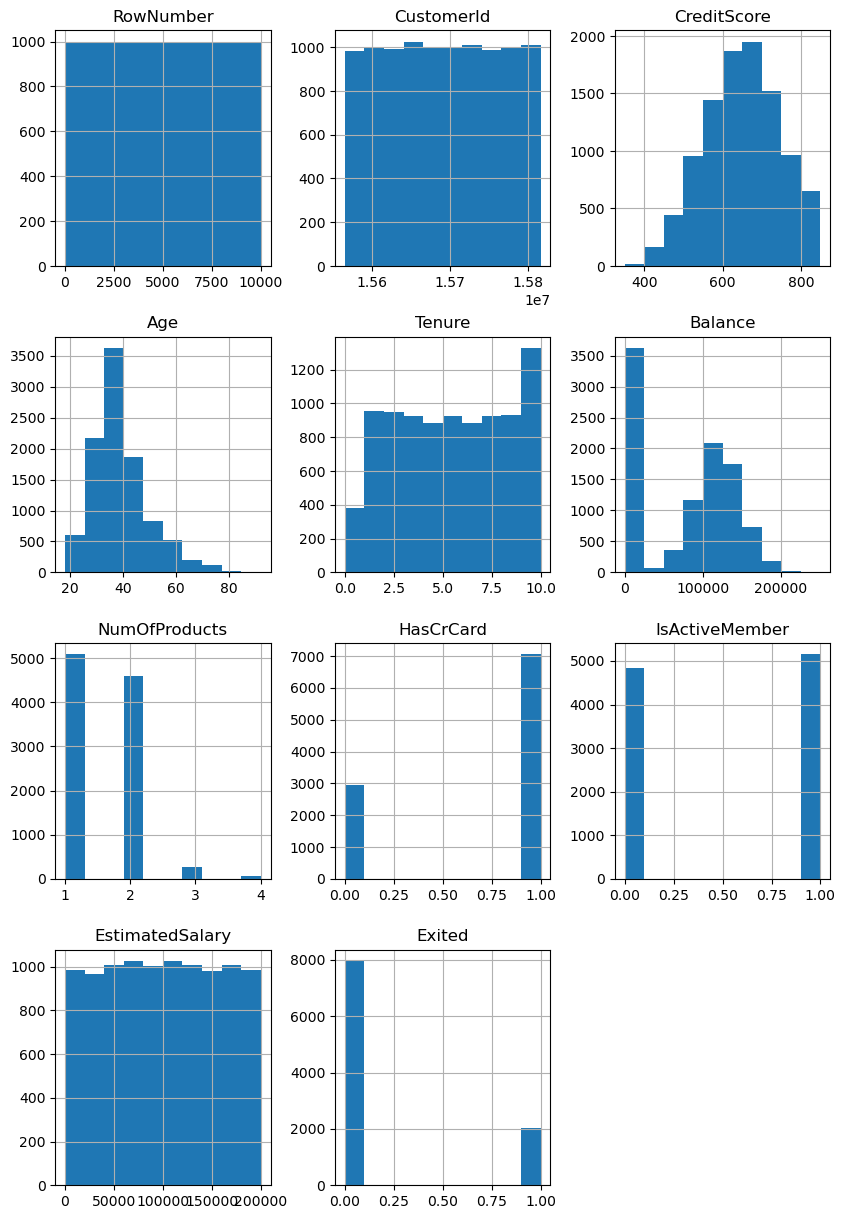

In [7]:
data.hist(figsize = (10, 15));

Единственное, что смущает в данных это большое количество пользователей у которых 0 баланс, но, скорей всего, это не является какой-то ошибкой, а вполне реальные данные, ведь человек может использовать карту для каких-то еденичных покупок из-за всевозможных кэшбеков по данной категории

*Описание данных*

0) RowNumber — индекс строки в данных

1) CustomerId — уникальный идентификатор клиента

2) Surname — фамилия

3) CreditScore — кредитный рейтинг

4) Geography — страна проживания

5) Gender — пол

6) Age — возраст

7) Tenure — сколько лет человек является клиентом банка

8) Balance — баланс на счёте

9) NumOfProducts — количество продуктов банка, используемых клиентом

10) HasCrCard — наличие кредитной карты

11) IsActiveMember — активность клиента

12) EstimatedSalary — предполагаемая зарплата


*Замечено:*

1) колонка 'Tenure' должна иметь целочисленный формат данных

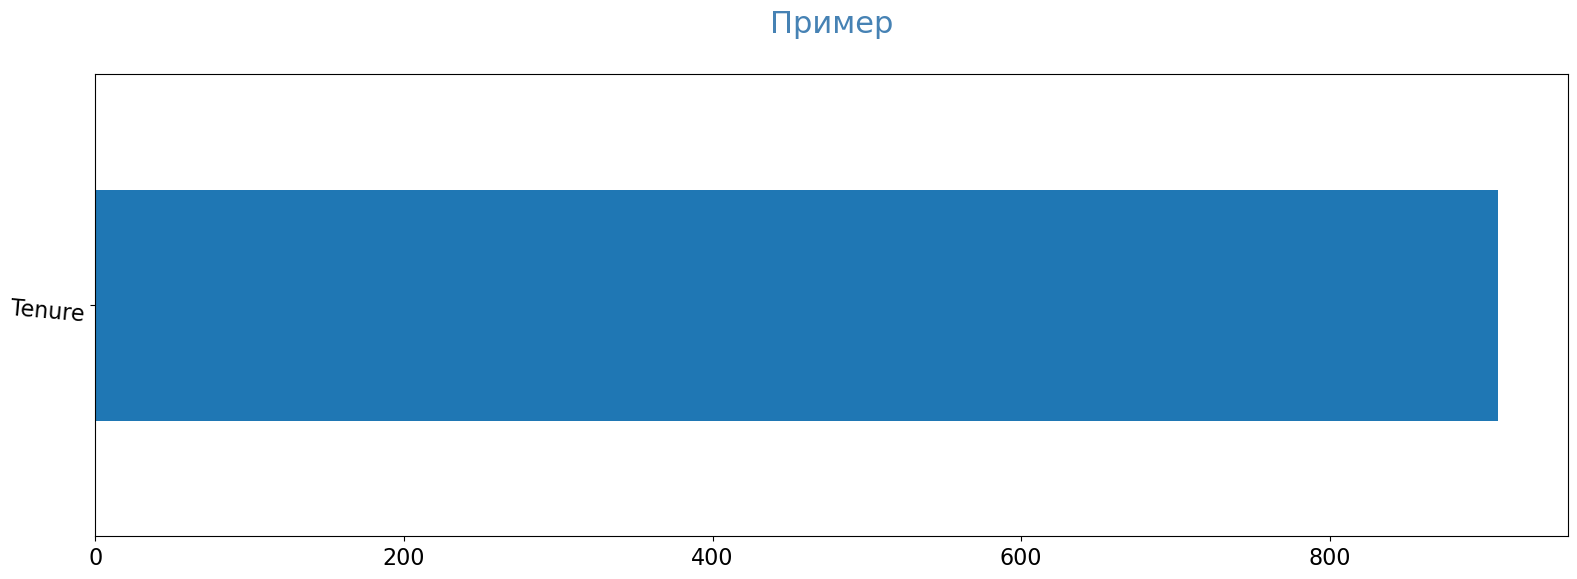

In [8]:
# напишем функцию, которая показывает наглядно количество пропусков
def pass_value_barh(df):
    try:
        (
            (df.isna().sum())
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось ')
# применим функцию 
pass_value_barh(data)

**Присутствуют пропуски только в колонке Tenure, которая указывает сколько лет человек является клиентом банка**

In [9]:
# посмотрим все уникальные значения колонки Tenure
print(*data['Tenure'].unique())

2.0 1.0 8.0 7.0 4.0 6.0 3.0 10.0 5.0 9.0 0.0 nan


**Колонка содержит только целые числа, поэтому нужно првести колонку к этому типу данных, пропуски в 'Tenure' скорей всего связаны с техническими проблемами, удалять 9% данных не будем, а заменим их медианным значением**

In [10]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median()).astype("Int64")

**Вывод: обхор данных закончился, необходимо было обработать единственную колонку 'Tenure', все остальные данные в норме и готовы к работе**

## Исследование задачи

Постановка задачи звучит следующим образом: Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Для начала исследуем баланс классов

Целевым признаком для нашей задачи будет являться колока 'Exited', которая показывает ушел клиент или нет 

Количество ушедших клиентов:  2037
Количество клиентов, котороые остались с банком:  7963


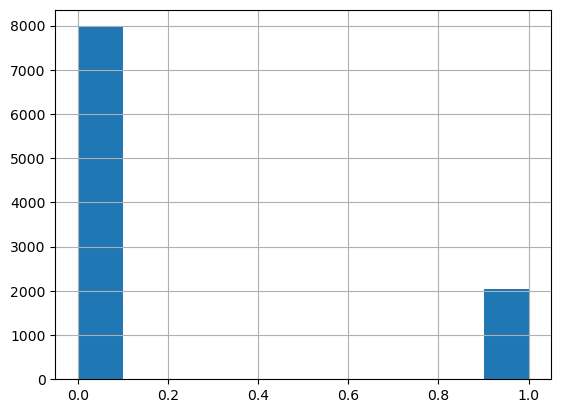

In [11]:
# исследуем баланс классов
data['Exited'].hist();
print('Количество ушедших клиентов: ', data['Exited'].sum())
print('Количество клиентов, котороые остались с банком: ', len(data[data['Exited'] == 0]))

Наблюдается явный дизбаланс классов в целевом признаке, количество ушедших клиентов почти в 4 раза меньше, чем количество клиентов, котороые остались с банком

Без сбалансирования класса разберем несколько модель машинного обучения для классификации

In [12]:
# перед конвертацией значений уберем колонки, которые не повлияют на предсказания
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  Int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: Int64(1), float64(2), int64(6), object(2)
memory usage: 869.3+ KB


In [14]:
# разабьем данные на 3 выборки: test, valid, train
data = pd.get_dummies(data, drop_first = True)
# уберем из features колонки, которые никак не смогут повлиять на предсказания: RowNumber, CustomerId, Surname
features = data.drop(['Exited'], axis = 1)
target = data['Exited']
# разделим target и features на обучающую выборку и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.2, random_state = 12345)
# теперь разделим обучающую выборку на обучающую и тестовую 
features_test, features_train, target_test, target_train = train_test_split(
    features_train, target_train, test_size = 0.75, random_state = 12345 
)
# масшатабируем данные
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
features_valid = scaler.transform(features_valid)
# посмотрим размеры каждой выборки
print(f'Обучающая выборка -> {features_train.shape}')
print(f'Тестовая выборка -> {features_test.shape}')
print(f'Валидационной выборка -> {features_valid.shape}')

Обучающая выборка -> (6000, 11)
Тестовая выборка -> (2000, 11)
Валидационной выборка -> (2000, 11)


Данные разделены верно, в соотношении 3:1:1

Для задачи классификации нужно будет рассмотреть 3 модели машинного обучения:

1) модели дерева решений для классификации

2) модели случайного леса для классификации

3) модели логистической регрессии регрессии

**Инициализация модели дерева решений для классификации**

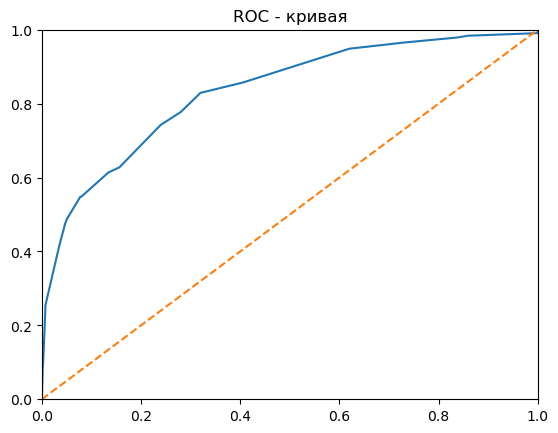

Метрика AUC-ROC: 0.8334720421158573
Модели дерева решений для классификации имеет следующие гиперпараметры: entropy, max_depth = 5, min_samples_split = 2
Значение F1 меры для этой модели -> 0.5767045454545454


In [15]:
best_cri = ''
all_cri = ['gini', 'entropy']
all_spli = ['best', 'random']
best_score_clas = best_depth = best_samples_split = 0
for cri in all_cri:
    for depth in range(1, 11):
        for samples_split in range(2, 7):
            model = DecisionTreeClassifier(
                criterion = cri, 
                max_depth = depth,
                min_samples_split = samples_split,
                random_state = 12345
            )
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            score = f1_score(target_valid, predictions)
            if score > best_score_clas:
                best_model_clas = model
                best_score_clas = score
                best_cri = cri
                best_depth = depth
                best_samples_split = samples_split
probabilities_valid = best_model_clas.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Модели дерева решений для классификации имеет следующие гиперпараметры: {best_cri}, max_depth = {best_depth}, min_samples_split = {best_samples_split}')
print(f'Значение F1 меры для этой модели -> {best_score_clas}')

**Инициализация модели случайного леса для классификации**

In [63]:
pd.options.mode.chained_assignment = None

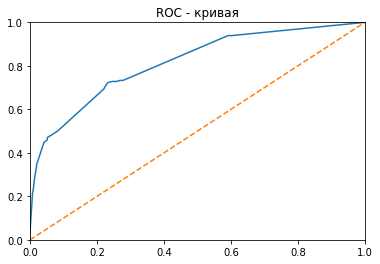

Метрика AUC-ROC: 0.8146205508351558
Модель случайного леса для классификации имеет следующие гиперпараметры: leaf_nodes = 8, max_depth = 5, features = None, est =  4
Значение F1 меры для этой модели -> 0.5592972181551977


In [64]:
best_score_forest = best_depth = best_est = best_leaf_nodes = best_score_forest = 0
array_features = ['sqrt', 'log2', None]
best_features = ''
for est in range(1, 17, 1):
    for depth in range(1, 17):
        for features in array_features:
            for leaf_nodes in range(3, 9):
                # инициализируем модель с параметрами
                model = RandomForestClassifier(
                    max_depth = depth, n_estimators = est, 
                    random_state = 12345, max_features = features, 
                    max_leaf_nodes = leaf_nodes
                )
                # обучим модель на тренировочной выборке
                model.fit(features_train, target_train)
                # получим предсказание модели на валидационной выборке
                predictions = model.predict(features_valid)
                # посчитаем значение rmse на валидационной выборке
                score = f1_score(target_valid, predictions)
                if score > best_score_forest:
                    best_model_forest = model
                    best_score_forest = score
                    best_est = est
                    best_depth = depth 
                    best_features = features
                    best_leaf_nodes = leaf_nodes
probabilities_valid = best_model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Модель случайного леса для классификации имеет следующие гиперпараметры: leaf_nodes = {best_leaf_nodes}, max_depth = {best_depth}, features = {best_features}, est =  {best_est}')
print(f'Значение F1 меры для этой модели -> {best_score_forest}')

**Инициализация модели логистичекой регрессии**

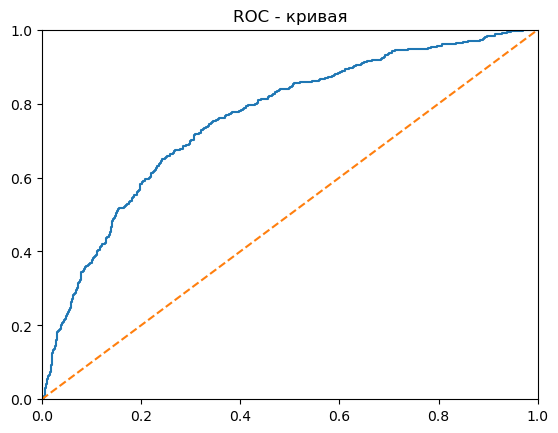

Метрика AUC-ROC: 0.7587568913947453
Значение F1 меры для этой модели ->: 0.5084269662921348


In [16]:
# инициализируем модель
model_linear = LogisticRegression(C = 0.01, solver = 'liblinear' )
# обучим модель на тренировочной выборке
model_linear.fit(features_train, target_train)
# получим предсказание модели на валидационной выборке
predictions = model.predict(features_valid)
# посчитаем значение rmse на валидационной выборке
score = f1_score(target_valid, predictions)
probabilities_valid = model_linear.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Значение F1 меры для этой модели ->: {score}')

**Вывод: Без сбалансирования классов в целевом признаке наилучшее значение F1 меры показала модель дерева решений для классификации, которая имеет следующие гиперпараметры: entropy, max_depth = 5, min_samples_split = 2. Значение F1 меры для этой модели: 0.5767045454545454. Метрика AUC-ROC для этой модели: 0.8334720421158573**

## Борьба с дисбалансом

Для того, чтобы искоренить дизбаланс классов можно воспользоваться методом увелечения выборки или же обучить модели со взвешиванием классов

Воспользуемся увелечением выборки и проверим метрики на наилучшей по показателям модели

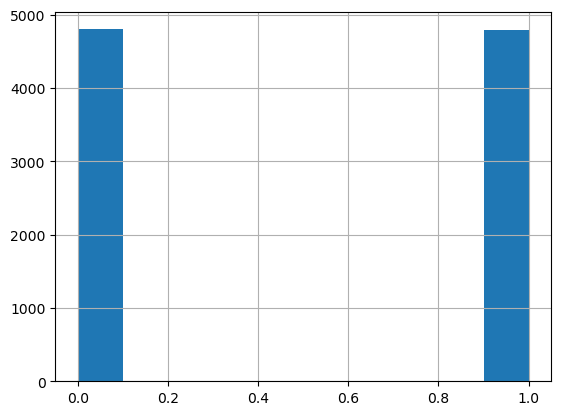

In [17]:
def upsample(features, target, repeat): 
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1]) 
    target_zeros = target[target == 0] 
    target_ones = target[target == 1] 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) 
    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=12345) 
    return features_upsampled, target_upsampled
rep = ceil(len(data[data['Exited'] == 0]) / data['Exited'].sum())
features_train_up, target_train_up = upsample(features_train, target_train, rep)
target_train_up.hist();

Данные сбалансированы, теперь на сбалансированных данных можно преобучить модкли и посмотрить метрики классификации

**Инициализация модели дерева решений для классификации с балансированными данными**

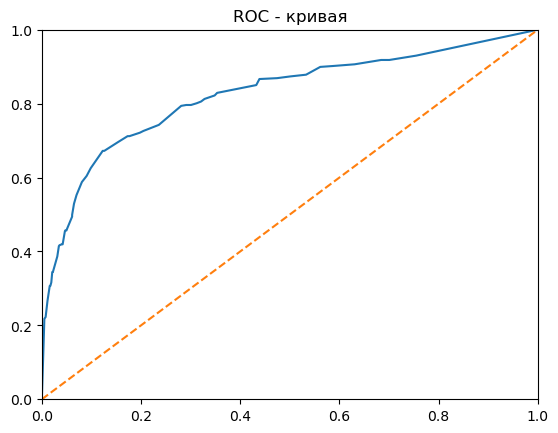

Метрика AUC-ROC: 0.8249291691914642
Модели дерева решений для классификации имеет следующие гиперпараметры: entropy, max_depth = 8, min_samples_split = 17
Значение F1 меры для этой модели -> 0.6043737574552684


In [18]:
best_cri_up = ''
all_cri = ['gini', 'entropy']
all_spli = ['best', 'random']
best_score_clas_up = 0
for cri in all_cri:
    for depth in range(1, 11):
        for samples_split in range(2, 20):
            model = DecisionTreeClassifier(
                criterion = cri, 
                max_depth = depth,
                min_samples_split = samples_split,
                random_state = 12345
            )
            model.fit(features_train_up, target_train_up)
            predictions = model.predict(features_valid)
            score = f1_score(target_valid, predictions)
            if score > best_score_clas_up:
                best_model_clas_up = model
                best_score_clas_up = score
                best_cri_up = cri
                best_depth_up = depth
                best_samples_split_up = samples_split
probabilities_valid = best_model_clas_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Модели дерева решений для классификации имеет следующие гиперпараметры: {best_cri_up}, max_depth = {best_depth_up}, min_samples_split = {best_samples_split_up}')
print(f'Значение F1 меры для этой модели -> {best_score_clas_up}')

**Инициализация модели случайного леса для классификации с балансированными данными**

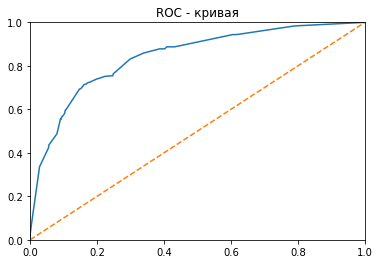

Метрика AUC-ROC: 0.8421965515855233
Модель случайного леса для классификации имеет следующие гиперпараметры: leaf_nodes = 8, max_depth = 16, features = None, est =  16
Значение F1 меры для этой модели -> 0.5979186376537371


In [68]:
best_depth = best_est = best_leaf_nodes = best_score_forest = 0
array_features = ['sqrt', 'log2', None]
best_features = ''
for est in range(1, 17, 1):
    for depth in range(1, 17):
        for features in array_features:
            for leaf_nodes in range(3, 9):
                # инициализируем модель с параметрами
                model = RandomForestClassifier(
                    max_depth = depth, n_estimators = est, 
                    random_state = 12345, max_features = features, 
                    max_leaf_nodes = leaf_nodes
                )
                # обучим модель на тренировочной выборке
                model.fit(features_train_up, target_train_up)
                # получим предсказание модели на валидационной выборке
                predictions = model.predict(features_valid)
                # посчитаем значение rmse на валидационной выборке
                score = f1_score(target_valid, predictions)
                if score > best_score_forest:
                    best_model_forest_up = model
                    best_score_forest_up = score
                    best_est = est
                    best_depth = depth 
                    best_features = features
                    best_leaf_nodes = leaf_nodes
probabilities_valid = best_model_forest_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Модель случайного леса для классификации имеет следующие гиперпараметры: leaf_nodes = {best_leaf_nodes}, max_depth = {best_depth}, features = {best_features}, est =  {best_est}')
print(f'Значение F1 меры для этой модели -> {best_score_forest_up}')

**Инициализация модели логистичекой регрессии с балансированнми данными**

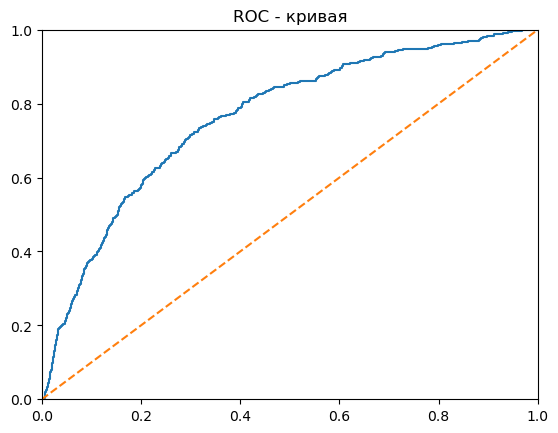

Метрика AUC-ROC: 0.7626114570972992
Значение F1 меры для этой модели ->: 0.5602240896358543


In [19]:
# инициализируем модель
model_linear = LogisticRegression(C = 0.01, solver = 'liblinear' )
# обучим модель на тренировочной выборке
model_linear.fit(features_train_up, target_train_up)
# получим предсказание модели на валидационной выборке
predictions = model.predict(features_valid)
# посчитаем значение rmse на валидационной выборке
score = f1_score(target_valid, predictions)
probabilities_valid = model_linear.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Значение F1 меры для этой модели ->: {score}')

Обученим модели со взвешиванием классов выборки и проверим метрики на наилучшей по показателям модели

**Инициализация модели дерева решений для классификации со взвешиванием классов выборки**

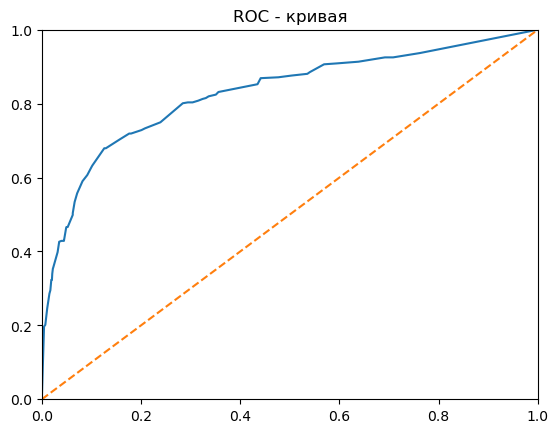

Метрика AUC-ROC: 0.8279686036765023
Модели дерева решений для классификации имеет следующие гиперпараметры: entropy, max_depth = 8, min_samples_split = 21
Значение F1 меры для этой модели -> 0.6037364798426745


In [20]:
best_cri_up = ''
all_cri = ['gini', 'entropy']
all_spli = ['best', 'random']
best_score_clas_up = 0
for cri in all_cri:
    for depth in range(1, 15):
        for samples_split in range(2, 27):
            model = DecisionTreeClassifier(
                criterion = cri, 
                max_depth = depth,
                min_samples_split = samples_split,
                class_weight = 'balanced', 
                random_state = 12345
            )
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            score = f1_score(target_valid, predictions)
            if score > best_score_clas_up:
                best_model_clas_up = model
                best_score_clas_up = score
                best_cri_up = cri
                best_depth_up = depth
                best_samples_split_up = samples_split
probabilities_valid = best_model_clas_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Модели дерева решений для классификации имеет следующие гиперпараметры: {best_cri_up}, max_depth = {best_depth_up}, min_samples_split = {best_samples_split_up}')
print(f'Значение F1 меры для этой модели -> {best_score_clas_up}')

**Инициализация модели случайного леса для классификации со взвешиванием классов выборки**

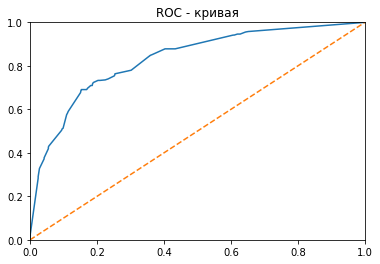

Метрика AUC-ROC: 0.8314316086298204
Модель случайного леса для классификации имеет следующие гиперпараметры: leaf_nodes = 8, max_depth = 16, features = None, est =  16
Значение F1 меры для этой модели -> 0.591123701605288


In [71]:
best_depth = best_est = best_leaf_nodes = best_score_forest = 0
array_features = ['sqrt', 'log2', None]
best_features = ''
for est in range(1, 17, 1):
    for depth in range(1, 17):
        for features in array_features:
            for leaf_nodes in range(3, 9):
                # инициализируем модель с параметрами
                model = RandomForestClassifier(
                    max_depth = depth, 
                    n_estimators = est, 
                    max_features = features, 
                    class_weight = 'balanced',
                    max_leaf_nodes = leaf_nodes,
                    random_state = 12345,
                )
                # обучим модель на тренировочной выборке
                model.fit(features_train, target_train)
                # получим предсказание модели на валидационной выборке
                predictions = model.predict(features_valid)
                # посчитаем значение rmse на валидационной выборке
                score = f1_score(target_valid, predictions)
                if score > best_score_forest:
                    best_model_forest_up = model
                    best_score_forest_up = score
                    best_est = est
                    best_depth = depth 
                    best_features = features
                    best_leaf_nodes = leaf_nodes
probabilities_valid = best_model_forest_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Модель случайного леса для классификации имеет следующие гиперпараметры: leaf_nodes = {best_leaf_nodes}, max_depth = {best_depth}, features = {best_features}, est =  {best_est}')
print(f'Значение F1 меры для этой модели -> {best_score_forest_up}')

**Инициализация модели логистичекой регрессии со взвешиванием классов выборки**

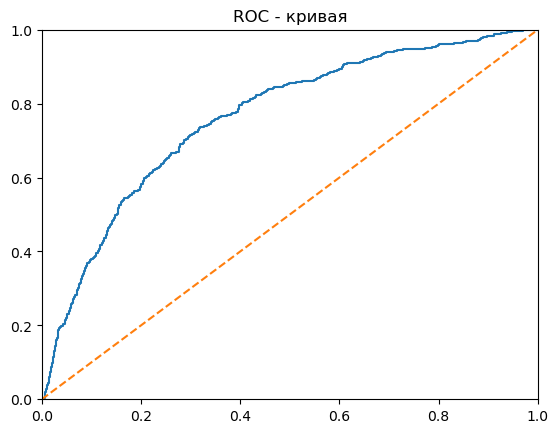

Метрика AUC-ROC: 0.7627945824667137
Значение F1 меры для этой модели ->: 0.5247706422018348


In [22]:
# инициализируем модель
model_linear = LogisticRegression(
    C = 0.01, 
    solver = 'liblinear', 
    class_weight = 'balanced'
)
# обучим модель на тренировочной выборке
model_linear.fit(features_train, target_train)
# получим предсказание модели на валидационной выборке
predictions = model.predict(features_valid)
# посчитаем значение rmse на валидационной выборке
score = f1_score(target_valid, predictions)
probabilities_valid = model_linear.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Значение F1 меры для этой модели ->: {score}')

**Вывод: Наилушая модель: модель дерева решений для классификации с балансированными данными. С показателями: Метрика AUC-ROC: 0.8217423411164096. Гиперпараметры модели: entropy, max_depth = 8, min_samples_split = 17
Значение F1 меры для этой модели -> 0.604. На это модели необходимо провести тестирование на тестовых данных**

## Тестирование модели

**После обучения модели на валидационной выборке проверим основные преспективные модели на тестовой выборке**

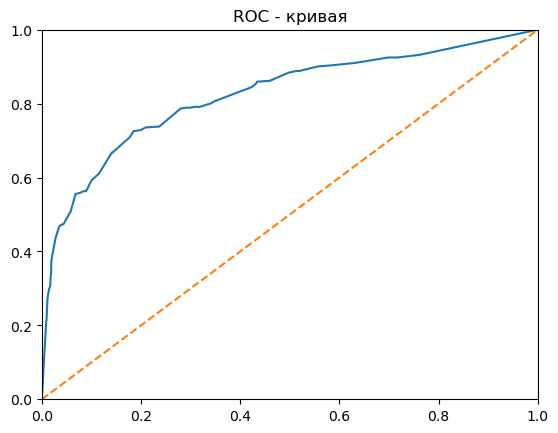

Метрика AUC-ROC: 0.8232908830794062
Значение F1 меры для этой модели -> 0.5663716814159292


In [23]:
model = DecisionTreeClassifier(
    criterion = 'entropy', 
    max_depth = 8,
    min_samples_split = 17,
    random_state = 12345
)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
score = f1_score(target_test, predictions)
probabilities_test = best_model_clas_up.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Значение F1 меры для этой модели -> {score}')

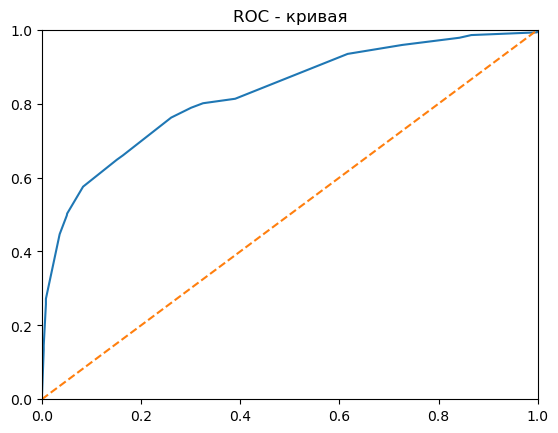

Метрика AUC-ROC: 0.8271571066982957
Значение F1 меры для этой модели -> 0.5938430983118174


In [24]:
model = DecisionTreeClassifier(
    criterion = 'entropy', 
    max_depth = 8,
    min_samples_split = 21,
    class_weight = 'balanced', 
    random_state = 12345
)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
score = f1_score(target_test, predictions)
probabilities_test = best_model_clas.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC - кривая')
plt.show()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'Метрика AUC-ROC: {auc_roc}')
print(f'Значение F1 меры для этой модели -> {score}')

Для модели дерева решений для классификации со взвешиванием классов выборки удалось достичь значения F1 меры больше 0.59

# Итоговый вывод: 
Перед тем, как разделять выборку на обучающую, валидационную и тестовую, была проведена предварительная подготовка датасета:

1) заполнены пропуски в данных

2) удалены категориальные столбцы, так как они никак не влияют на качество обучения 

3) категориальные признаки были преобразованы в бинарные 

4) к количественным признакам было применено масштабирование, чтобы при обучении не получилось так, что какой-то признак с более высоким значением был засчитан как более значимый

5) Проверка датасета на наличие дисбаланса показала, что в целевом признаке наблюдается достаточно сильный дисбаланс классов - только 20% отражают факт ухода клиента:

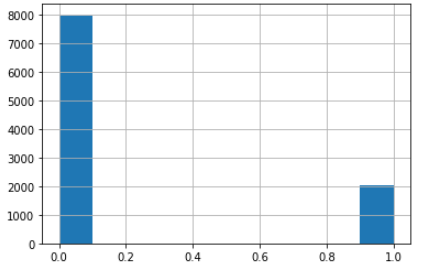

6) была проведена борьба с дизбалансом с помощью 2 методов

7) В результате борьбы с дисбанансом классов были получены следующие выводы:

    1) Уменьшение и увеличение выборки позволяют достичь примерно одинаковое значение F1-score.
    
    2) Наибольшее значение метрики F1-score получено на модели  дерева решений для классификации со взвешиванием классов выборки. Поэтому для финального тестирования была использована именно она.
    3) Значение метрики AUC-ROC всегда стабильно выше F1-score и колеблется в районе 80%.
    
8) наилучшая модель была протестирована на тестовой выборке. Значения ключевых метрик получились следующие:

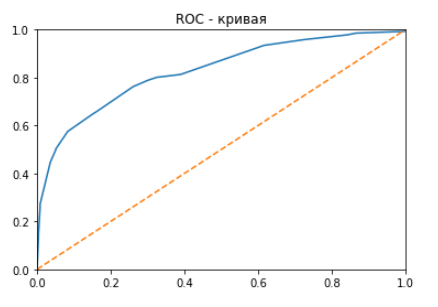

    1) F1-score = 0.60 (выше необходимого значения)
    
    2)AUC-ROC = 0.83 (достаточно близко к единице)